# How to Train YOLOv9 on a Custom Dataset
---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov9-model/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/WongKinYiu/yolov9)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/XHT2c8jT3Bc)
[![arXiv](https://img.shields.io/badge/arXiv-2402.13616-b31b1b.svg)](https://arxiv.org/pdf/2402.13616.pdf)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri May 17 09:07:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Counting objects: 100% (218/218), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 325 (delta 159), reused 156 (delta 156), pack-reused 107
Receiving objects: 100% (325/325), 2.23 MiB | 25.15 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.8 MB/s eta 0:00:00


**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [4]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.9/74.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.4 MB/s eta 0:00:00


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [5]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [6]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 May 17 09:09 .
drwxr-xr-x 1 root root      4096 May 17 09:09 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


## Download example data

**NOTE:** If you want to run inference using your own file as input, simply upload image to Google Colab and update `SOURCE_IMAGE_PATH` with the path leading to your file.

In [7]:
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg

In [8]:
SOURCE_IMAGE_PATH = f"{HOME}/dog.jpeg"

## Detection with pre-trained COCO model

### gelan-c

In [9]:
!python detect.py --weights {HOME}/weights/gelan-c.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/gelan-c.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 467 layers, 25472640 parameters, 0 gradients, 102.8 GFLOPs
image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 handbag, 148.5ms
Speed: 0.5ms pre-process, 148.5ms inference, 754.3ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


**NOTE:** By default, the results of each subsequent inference sessions are saved in `{HOME}/yolov9/runs/detect/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

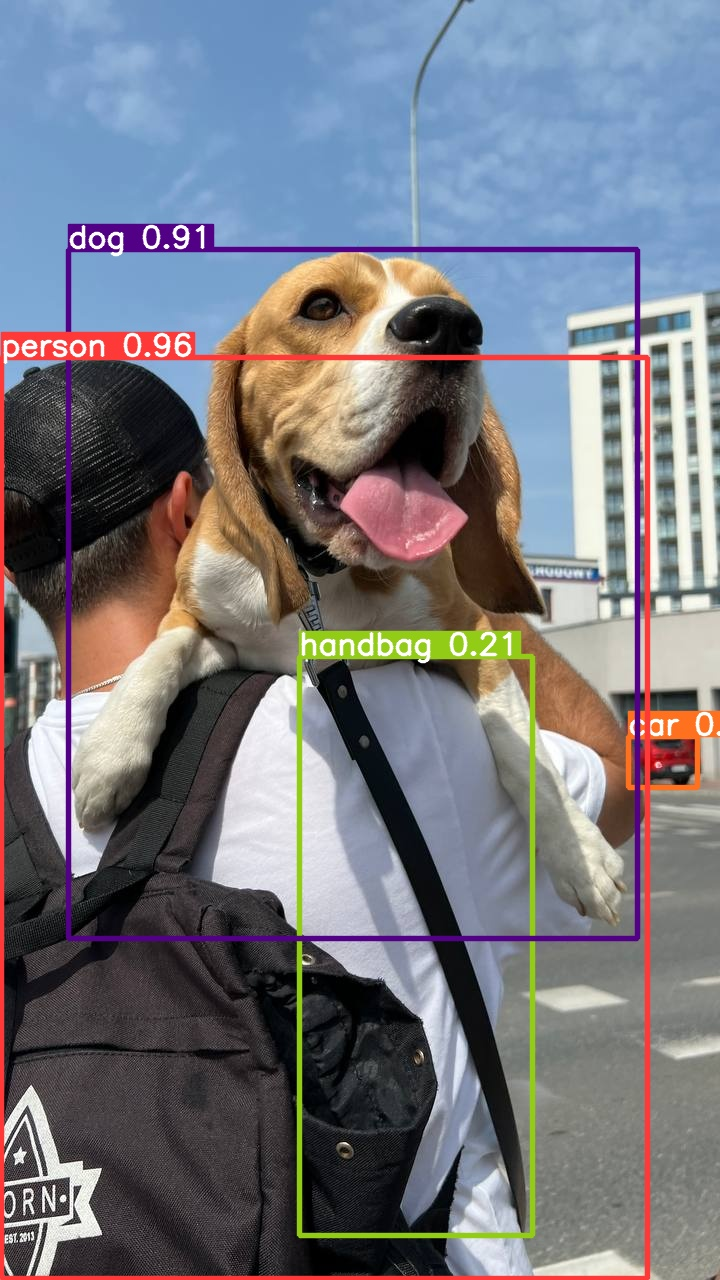

In [10]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp/dog.jpeg", width=600)

## yolov9-e

In [11]:
!python detect.py --weights {HOME}/weights/yolov9-e.pt --conf 0.1 --source {HOME}/data/dog.jpeg --device 0

detect: weights=['/content/weights/yolov9-e.pt'], source=/content/data/dog.jpeg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 1119 layers, 69470144 parameters, 0 gradients, 244.0 GFLOPs
image 1/1 /content/data/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 1 backpack, 1 handbag, 260.0ms
Speed: 0.5ms pre-process, 260.0ms inference, 925.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


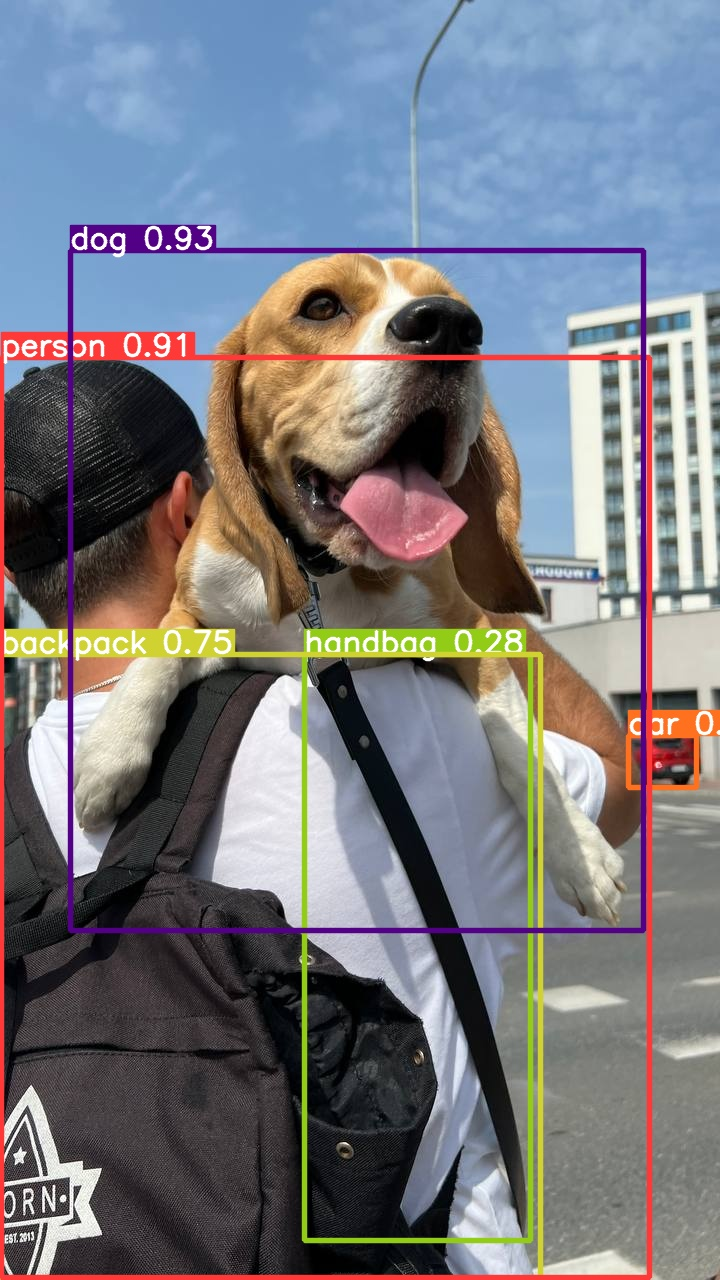

In [12]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/detect/exp2/dog.jpeg", width=600)

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [13]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [15]:
import roboflow

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
version = project.version(8)
dataset = version.download("yolov9")

You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


## Train Custom Model

In [16]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 25 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-05-17 09:13:08.430282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 09:13:08.430332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 09:13:08.431762: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-17 09:13:09.485966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=/content/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/content/yolov9/football-players-detection-8/data.yaml, hyp=hyp.scratch-high.yaml, epochs=25, batch_size=16, imgsz=640, rect=False, resume=False

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [17]:
!ls {HOME}/yolov9/runs/train/exp/

confusion_matrix.png				    P_curve.png       train_batch2.jpg
events.out.tfevents.1715937190.f38b3765371f.2039.0  PR_curve.png      val_batch0_labels.jpg
F1_curve.png					    R_curve.png       val_batch0_pred.jpg
hyp.yaml					    results.csv       val_batch1_labels.jpg
labels_correlogram.jpg				    results.png       val_batch1_pred.jpg
labels.jpg					    train_batch0.jpg  weights
opt.yaml					    train_batch1.jpg


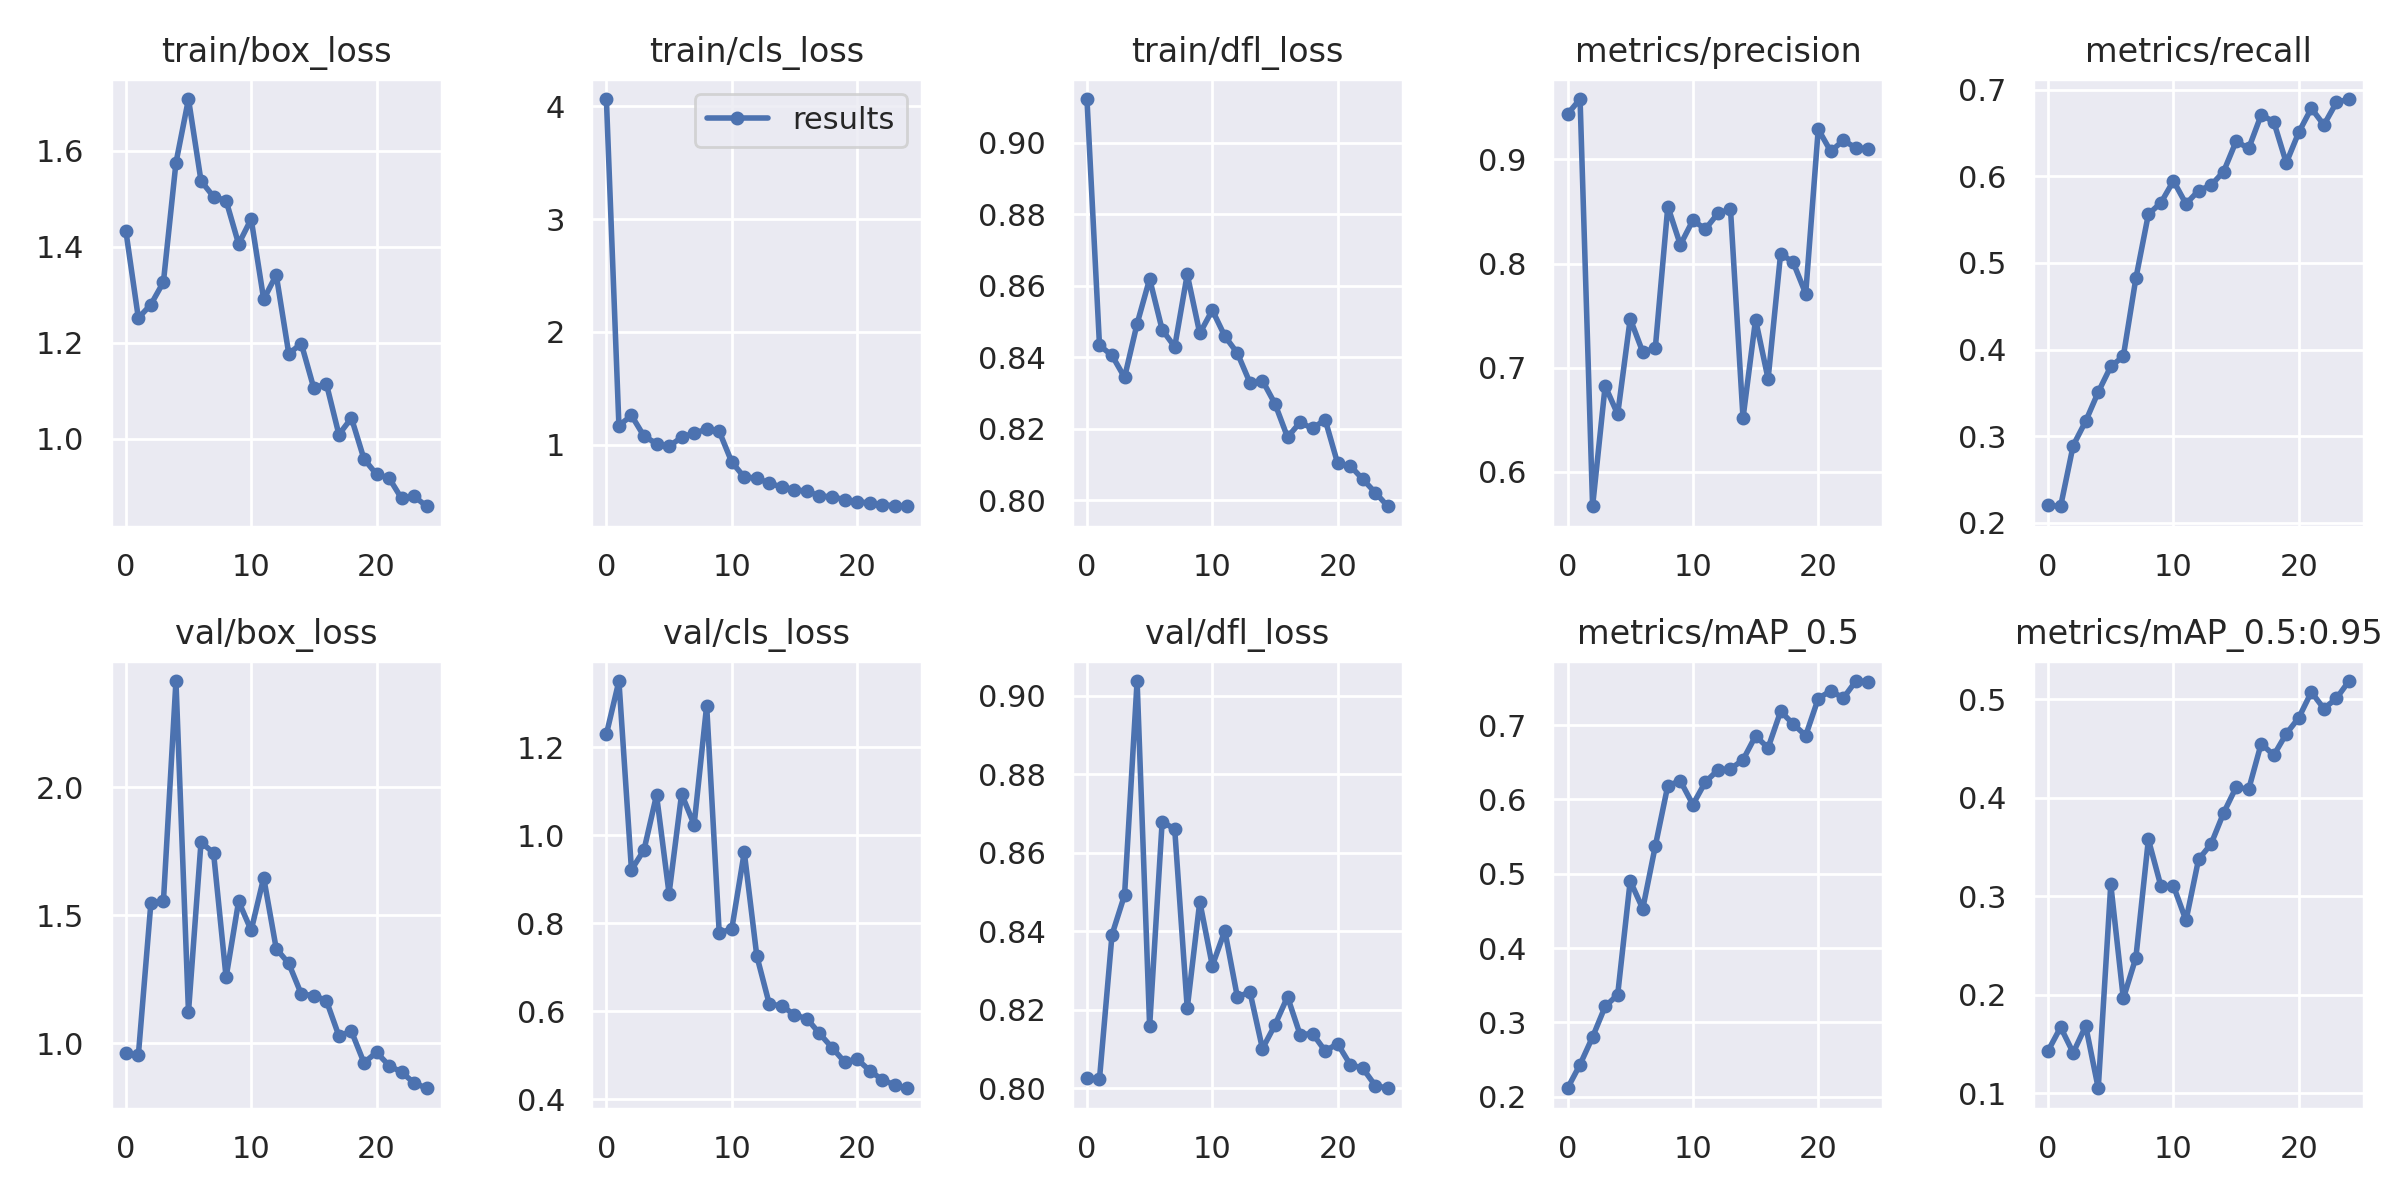

In [18]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/results.png", width=1000)

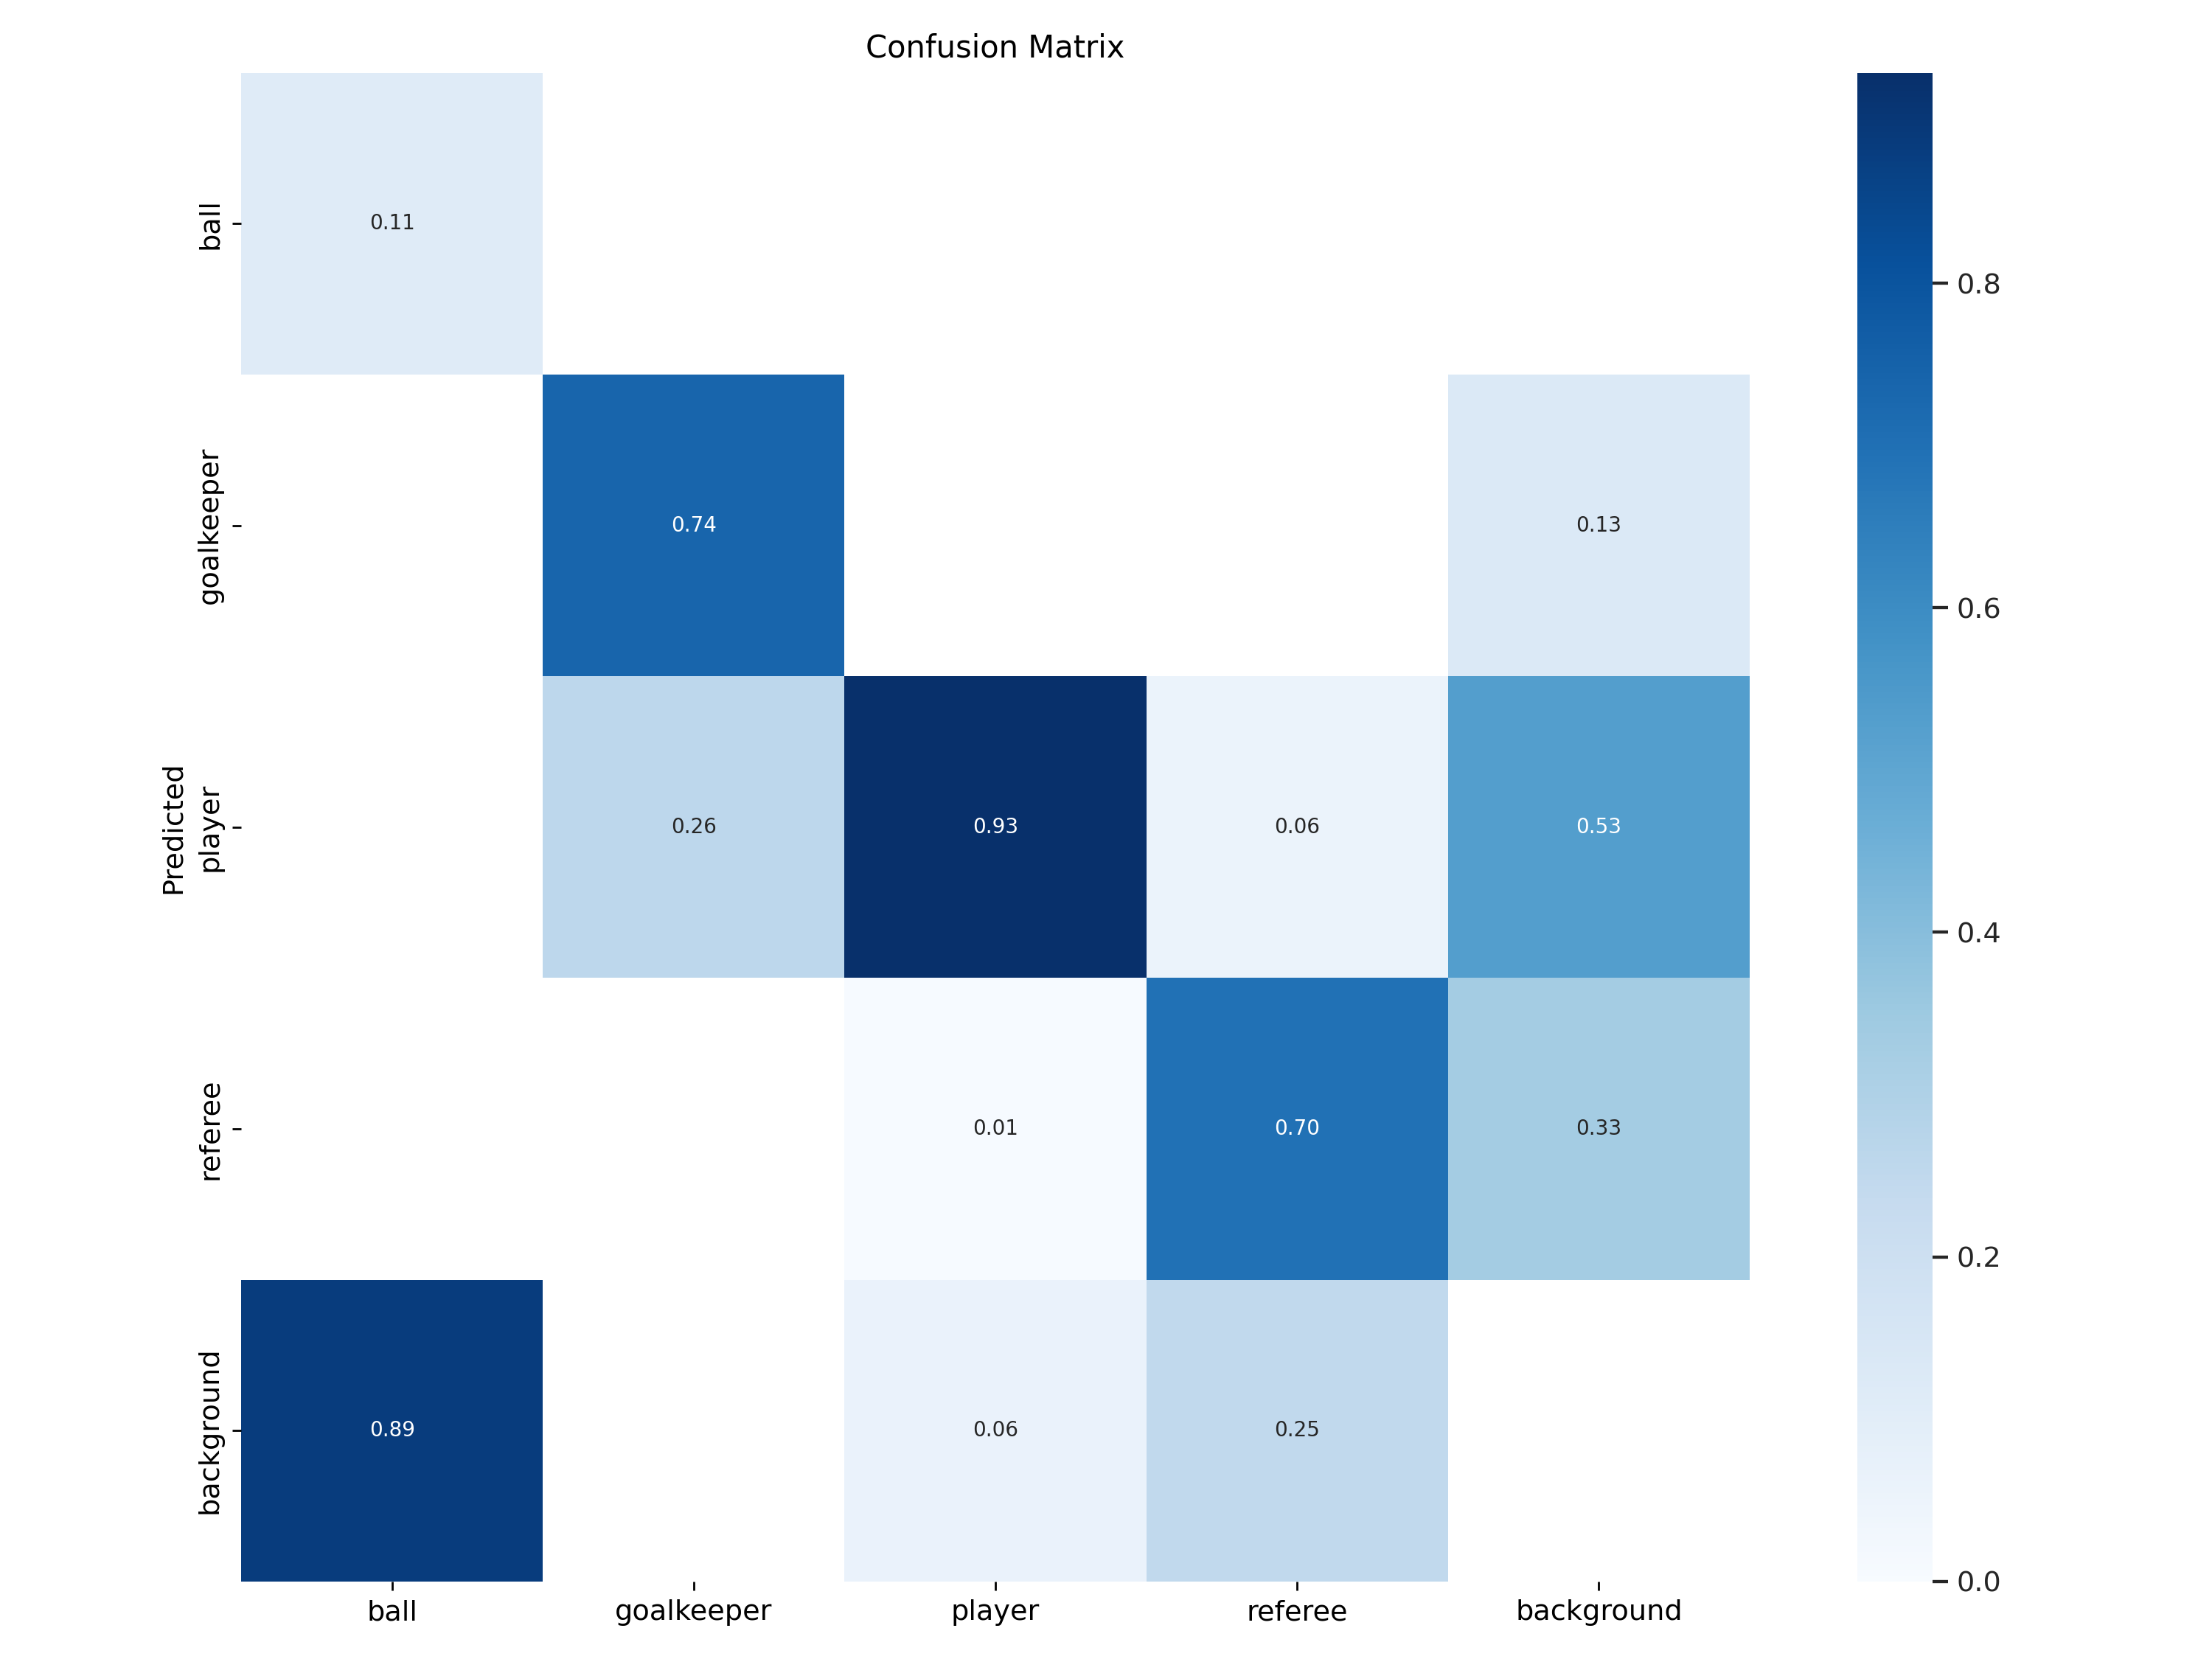

In [19]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/confusion_matrix.png", width=1000)

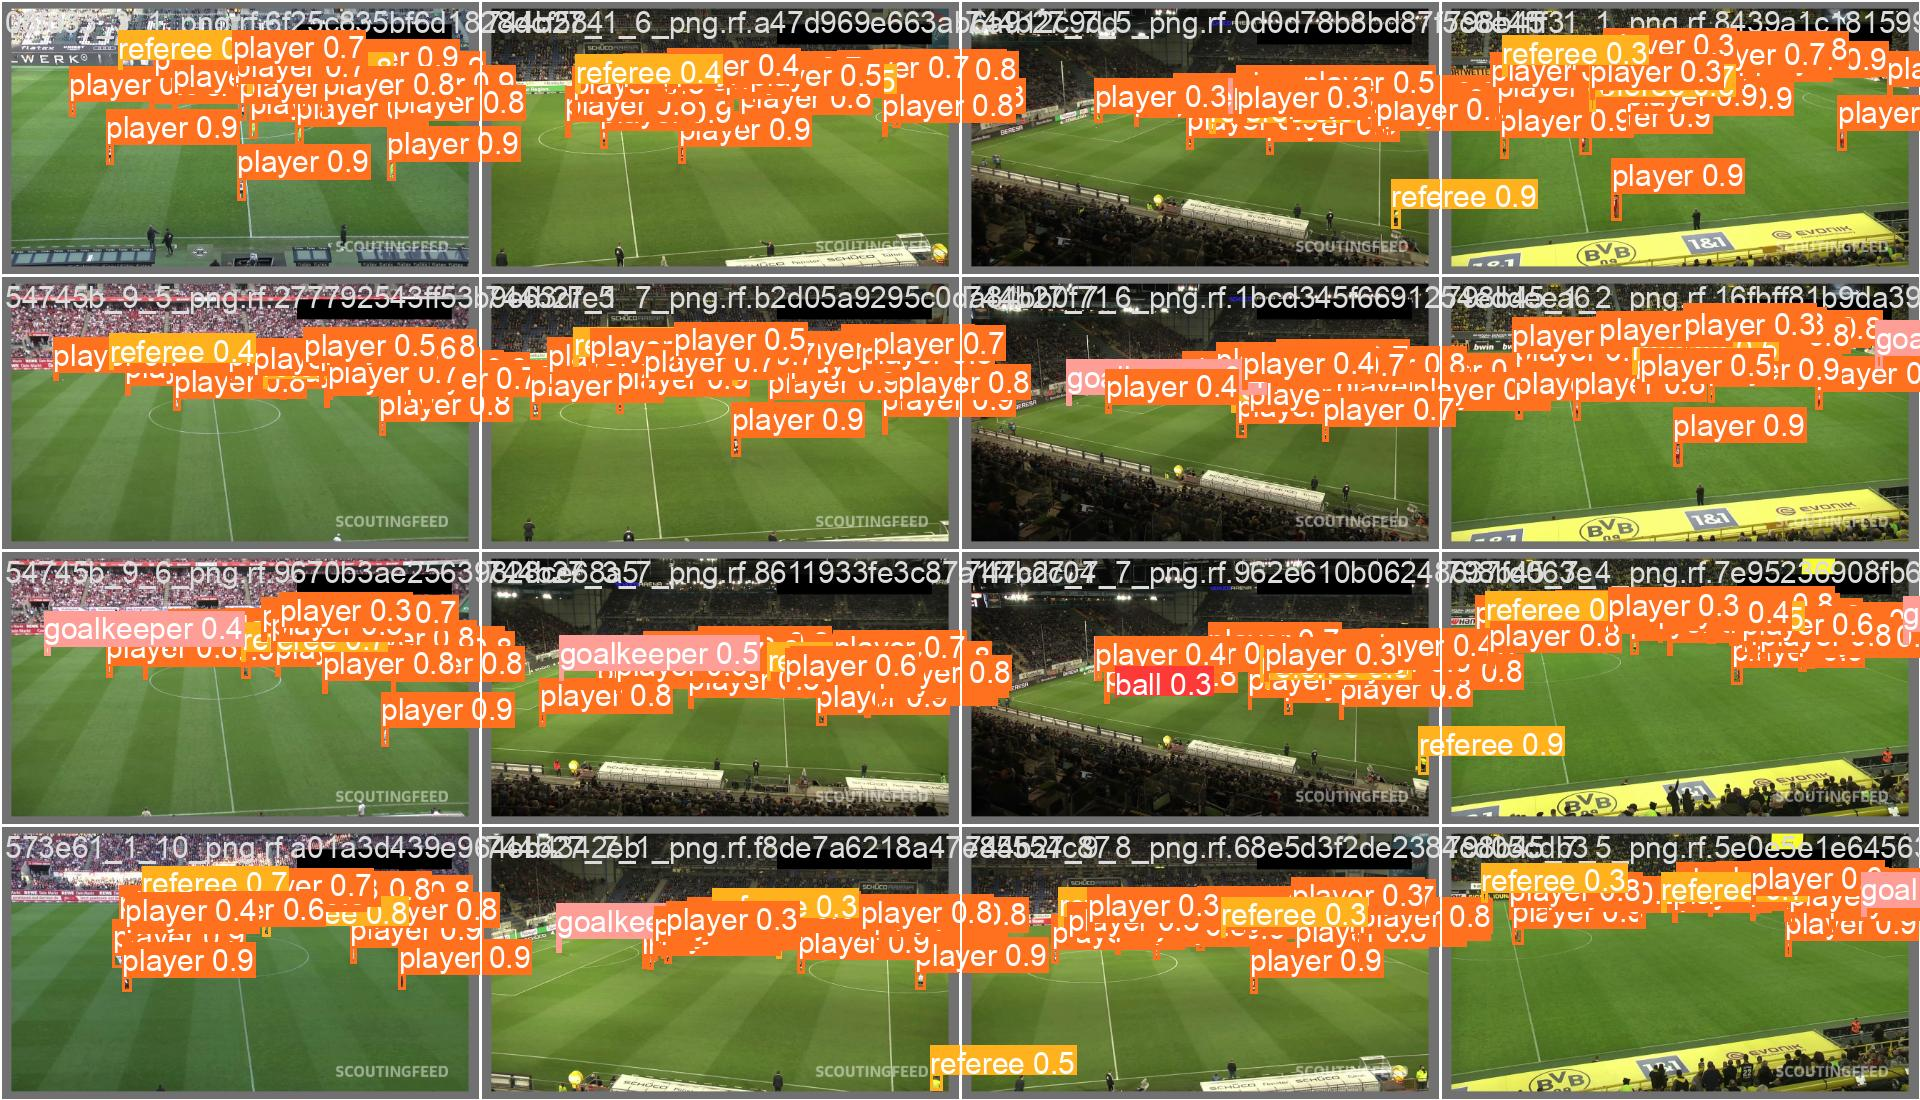

In [20]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [21]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt

/content/yolov9
val: data=/content/yolov9/football-players-detection-8/data.yaml, weights=['/content/yolov9/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25414044 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/football-players-detection-8/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100% 38/38 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
        

## Inference with Custom Model

In [22]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp/weights/best.pt'], source=/content/yolov9/football-players-detection-8/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25414044 parameters, 0 gradients, 102.5 GFLOPs
image 1/13 /content/yolov9/football-players-detection-8/test/images/40cd38_7_6_png.rf.68ef7fcd663cdf0f5b96bacdbcd94e07.jpg: 736x1280 23 players, 95.9ms
image 2/13 /content/yolov9/football-players-detection-8/test/images/42ba34_1_5_png.rf.4337fde8fbe3640cf4351fb41ac9c3ca.jpg: 736x1280 1 ball, 2 go

**NOTE:** Just like behore, the inference results have been saved in the appropriate directory inside `{HOME}/yolov9/runs/detect/`. Let's examine few of those results.

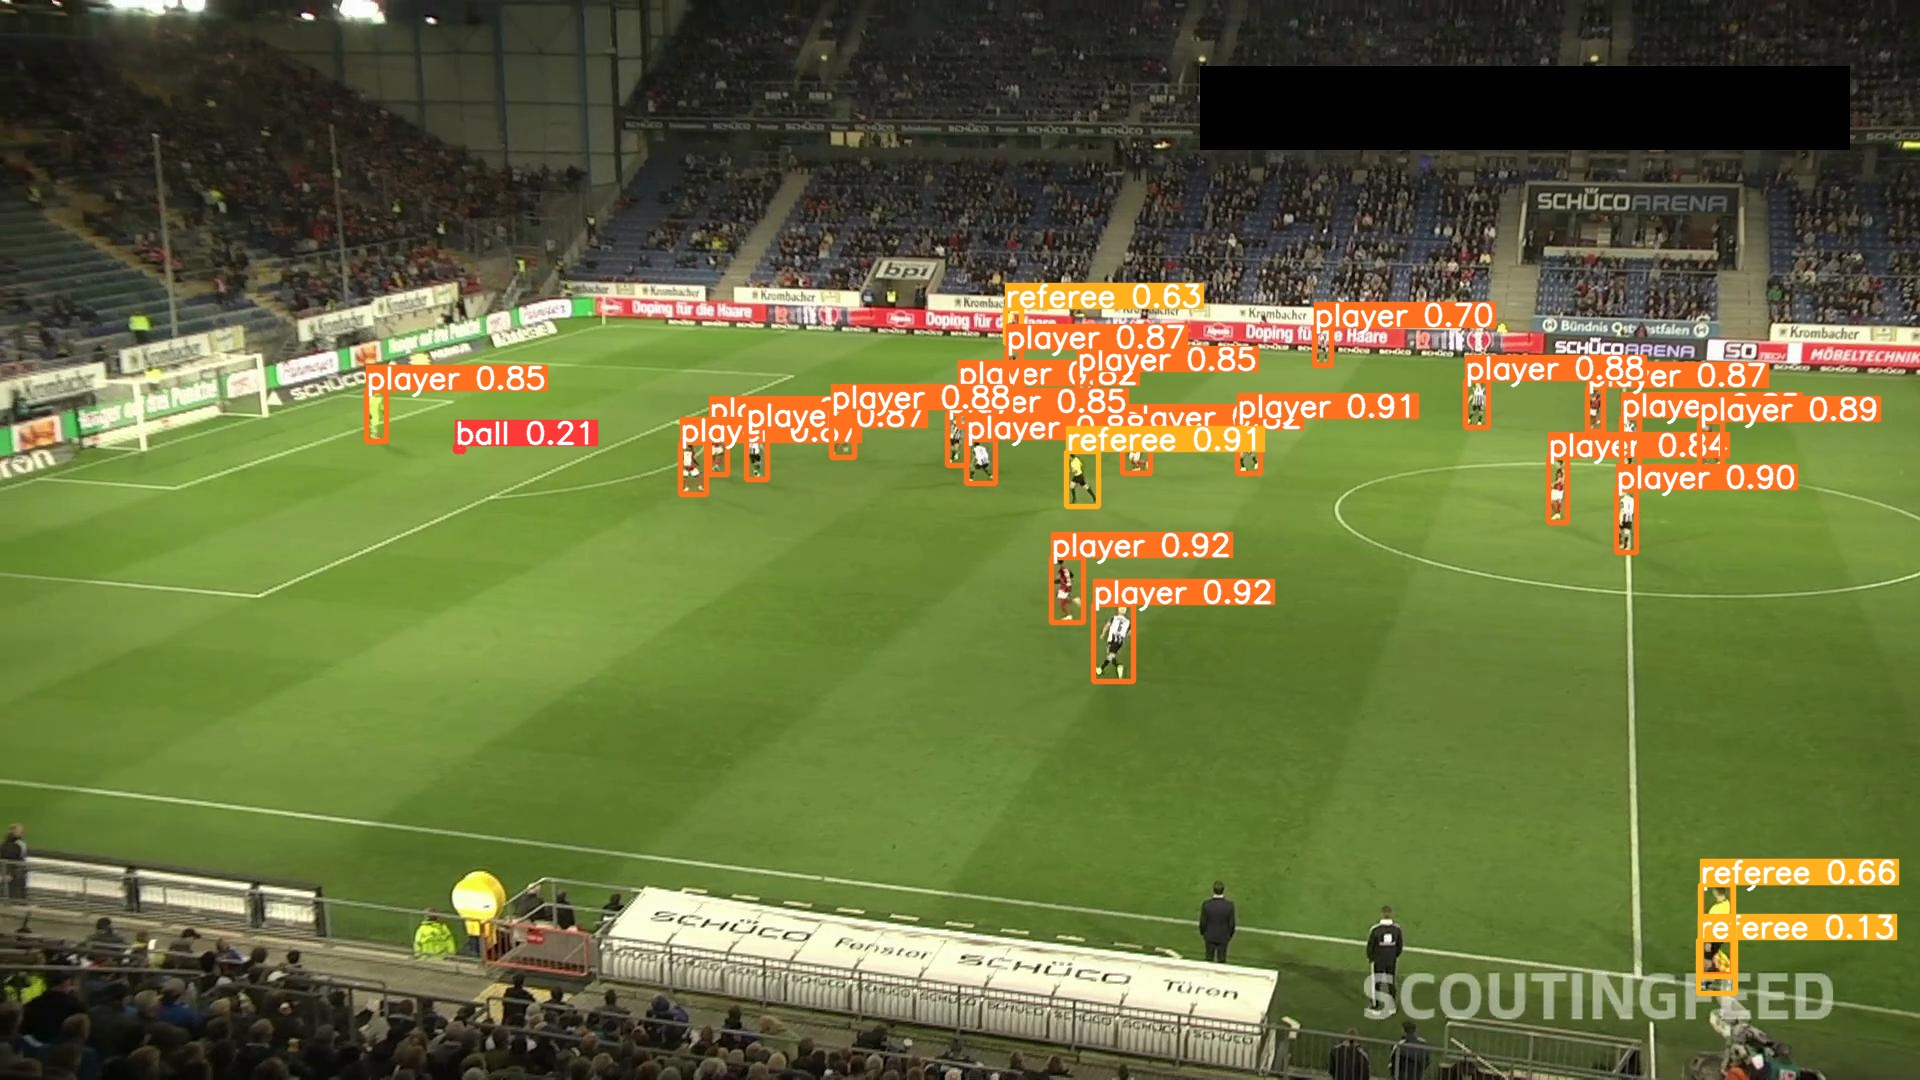

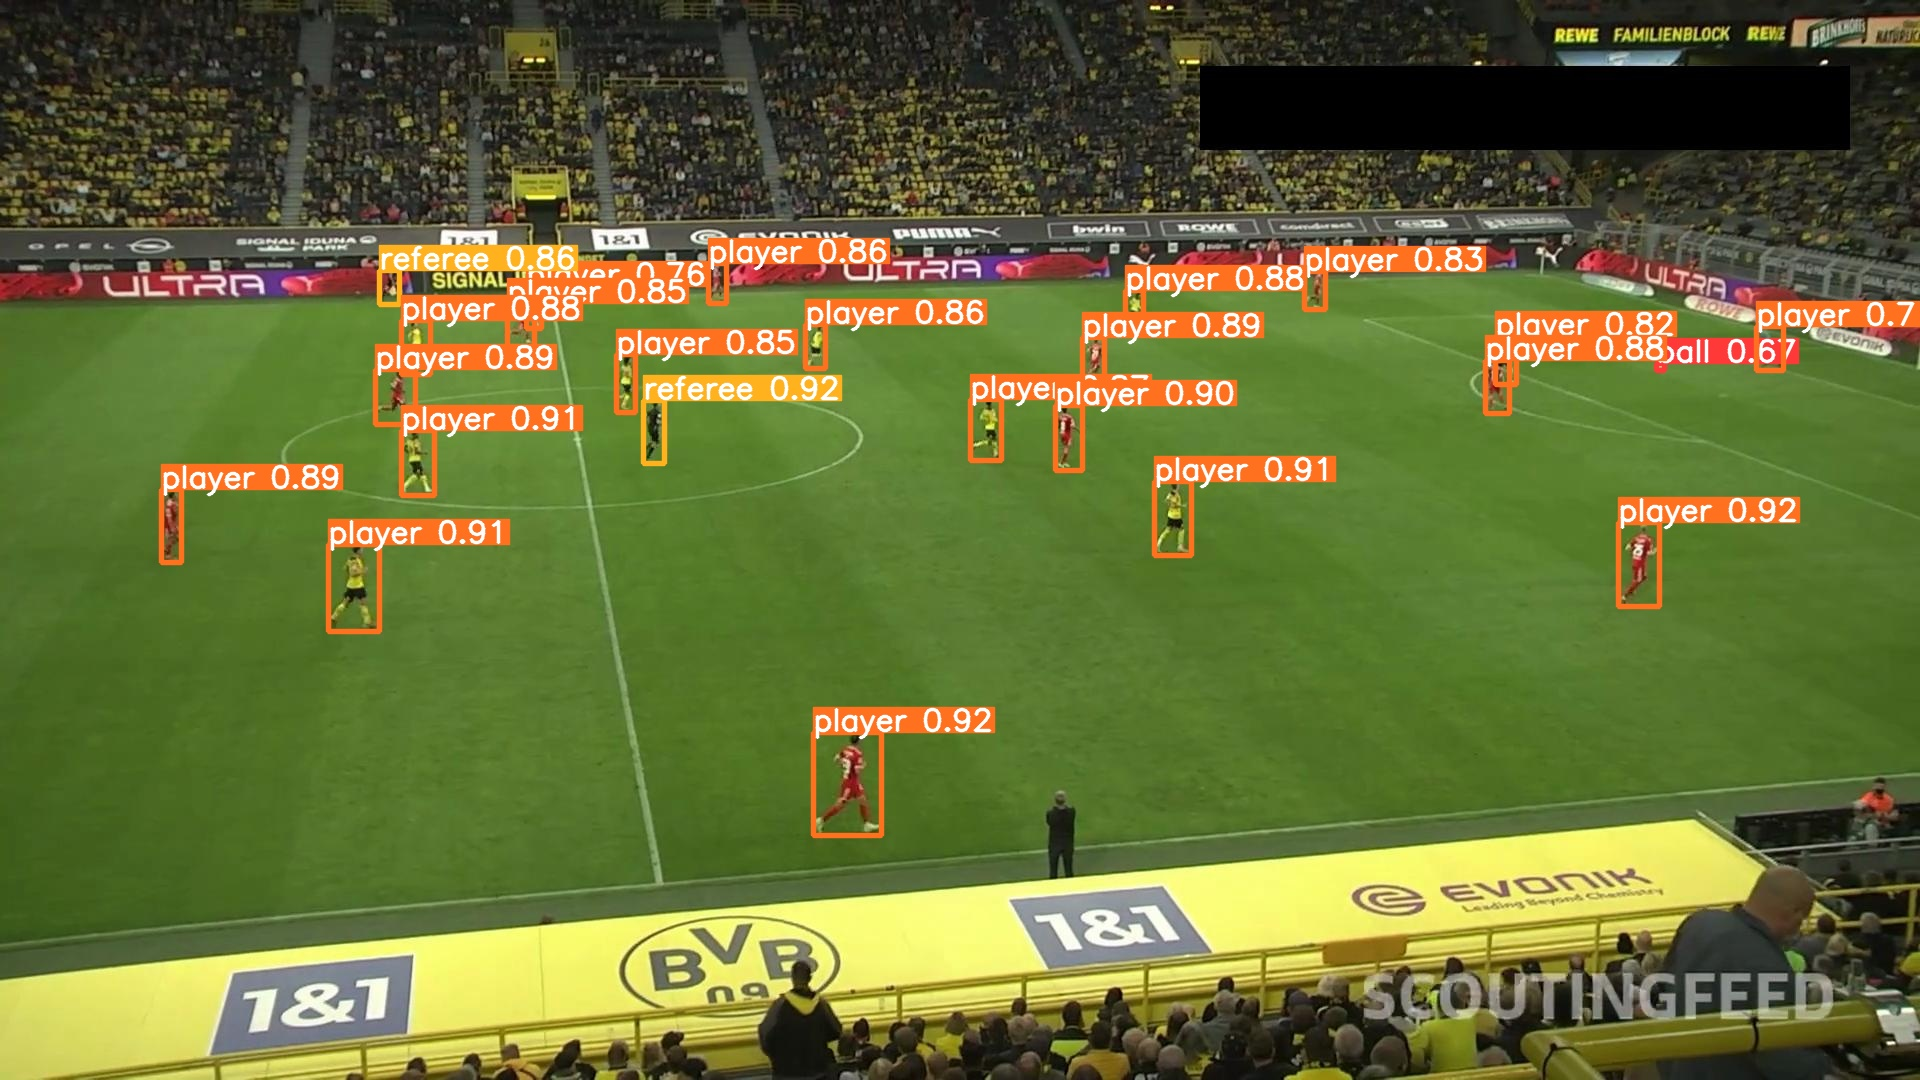

In [23]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp3/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))

## BONUS: Deploy YOLOv9 Model with Inference

**NOTE:** To deploy the model and display inference results, we will need two additional packages - [`inference`](https://pypi.org/project/inference) and [`supervision`](https://pypi.org/project/supervision). Let's install and import them!

In [ ]:
!pip install -q inference supervision

In [ ]:
import cv2
import random
import getpass

import supervision as sv

from inference import get_model

%matplotlib inline

**NOTE:** Before using your model in Inference, you first need to upload your weights to Roboflow Universe. Ensure to specify the correct `model_type` - `yolov9`, and that the project version matches the version of the dataset you used for training, denoted by `[1]`. In my case, it's `6`.

![YOLOv9 Benchmark](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/upload-roboflow-model.png)



In [ ]:
version.deploy(model_type="yolov9", model_path=f"{HOME}/yolov9/runs/train/exp")

View the status of your deployment at: https://app.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/6
Share your model with the world at: https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc/model/6


**NOTE:** Now we can download our model anywhere using the assigned `model_id` denoted by `[2]`. In my case `football-players-detection-3zvbc/6`. To download the model you will need your [`ROBOFLOW_API_KEY`](https://docs.roboflow.com/api-reference/authentication).




In [ ]:
ROBOFLOW_API_KEY = getpass.getpass()

model = get_model(model_id="football-players-detection-3zvbc/8", api_key=ROBOFLOW_API_KEY)

··········


**NOTE:** Let's pick random image from our test subset and detect objects using newly fine-tuned model.

In [ ]:
image_paths = sv.list_files_with_extensions(
    directory=f"{dataset.location}/test/images",
    extensions=['png', 'jpg', 'jpeg']
)
image_path = random.choice(image_paths)
image = cv2.imread(image_path)

result = model.infer(image, confidence=0.1)[0]
detections = sv.Detections.from_inference(result)

**NOTE:** Finally, let's use supervision and [annotate](https://supervision.roboflow.com/develop/annotators/) our results.

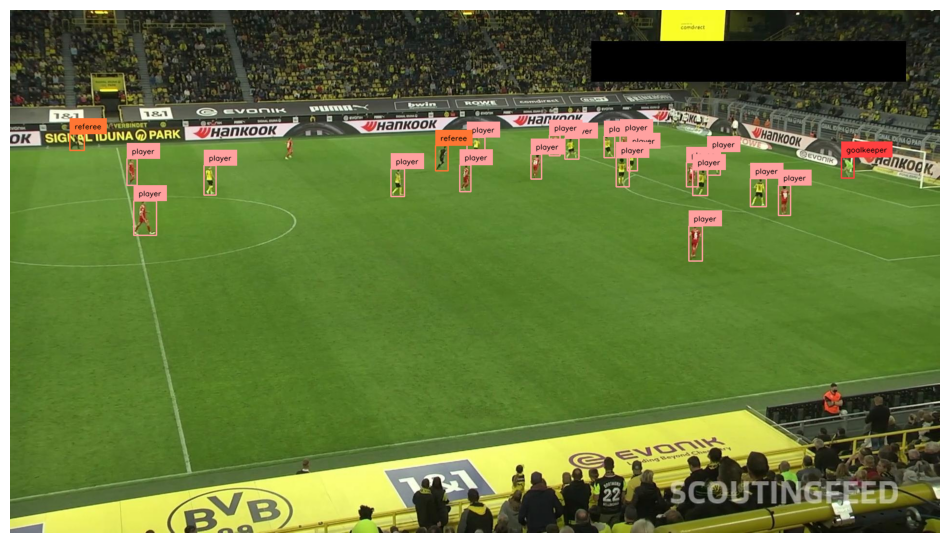

In [ ]:
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)
bounding_box_annotator = sv.BoundingBoxAnnotator()

annotated_image = image.copy()
annotated_image = bounding_box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)